In [1]:
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import requests
import seaborn as sns
import datetime as dt

sns.set_theme()
pd.options.display.float_format = '{:.2f}'.format

In [2]:
df = pd.read_csv('covid_preprocessed.csv', index_col=0)
df

Country  Total Cases  Total Deaths  Total Recovered  \
0                      USA     83170407    1021089.00      80757424.00   
1                    India     43085166     523889.00      42541887.00   
2                   Brazil     30460997     663657.00      29554308.00   
3                   France     28690748     146142.00      27163913.00   
4                  Germany     24791190     135947.00      22658600.00   
..                     ...          ...           ...              ...   
212               Anguilla         2788          9.00          2766.00   
213  Saint Pierre Miquelon         2701          1.00          2449.00   
215      Wallis and Futuna          454          7.00           438.00   
216             Montserrat          273          2.00           181.00   
227                  China       217836       5112.00        196458.00   

     Active Cases  Serious, Critical  Total Cases/1M pop  Deaths/1M pop  \
0      1391894.00            1550.00           248601.00        3052.00   
1        19390.00             698.00            30669.00         373.00   
2       243032.00            8318.00           141466.00        3082.00   
3      1380693.00            1511.00           437774.00        2230.00   
4      1996643.00            1446.00           294173.00        1613.00   
..            ...                ...                 ...            ...   
212         13.00               4.00           182844.00         590.00   
213        251.00               1.00           470394.00         174.00   
215          9.00                NaN            41732.00         643.00   
216         90.00                NaN            54622.00         400.00   
227      16266.00             615.00              151.00           4.00   

      Total Tests  Tests/1M pop    Population          Continent  \
0   1006269592.00    3007793.00  334554103.00      North America   
1    838628250.00     596961.00 1404828550.00               Asia   
2     63776166.00     296187.00  215324039.00      South America   
3    269816888.00    4116967.00   65537780.00             Europe   
4    122332384.00    1451601.00   84274119.00             Europe   
..            ...           ...           ...                ...   
212      51382.00    3369753.00      15248.00      North America   
213      23446.00    4083246.00       5742.00      North America   
215      20508.00    1885100.00      10879.00  Australia/Oceania   
216      10135.00    2027811.00       4998.00      North America   
227  160000000.00     111163.00 1439323776.00               Asia   

     Active Cases/1M pop        Date  
0                4160.00  2022-05-03  
1                  14.00  2022-05-03  
2                1129.00  2022-05-03  
3               21067.00  2022-05-03  
4               23692.00  2022-05-03  
..                   ...         ...  
212               853.00  2022-05-03  
213             43713.00  2022-05-03  
215               827.00  2022-05-03  
216             18007.00  2022-05-03  
227                11.00  2022-05-03  

[211 rows x 14 columns]

In [3]:
df.dtypes

Country                 object
Total Cases              int64
Total Deaths           float64
Total Recovered        float64
Active Cases           float64
Serious, Critical      float64
Total Cases/1M pop     float64
Deaths/1M pop          float64
Total Tests            float64
Tests/1M pop           float64
Population             float64
Continent               object
Active Cases/1M pop    float64
Date                    object
dtype: object

## Add Rate columns ##

In [4]:
df['Death rate'] = df['Total Deaths'] / df['Total Cases']
df['Recovery rate'] = df['Total Recovered'] / df['Total Cases']
df['Active rate'] = df['Active Cases'] / df['Total Cases']
df['Serious rate'] = df['Serious, Critical'] / df['Active Cases']
df['Cases per test'] = df['Total Cases'] / df['Total Tests']

## Correlation Matrix giữa các thuộc tính ##

Ta sẽ tiến hành xem xét mức độ tương quan giữa các cột trong dataframe này với nhau. Ta sẽ xét các thuộc tính có mức độ tương quan thuận cao là 1, tương quan nghịch cao là -1, còn lại là 0

<AxesSubplot:>

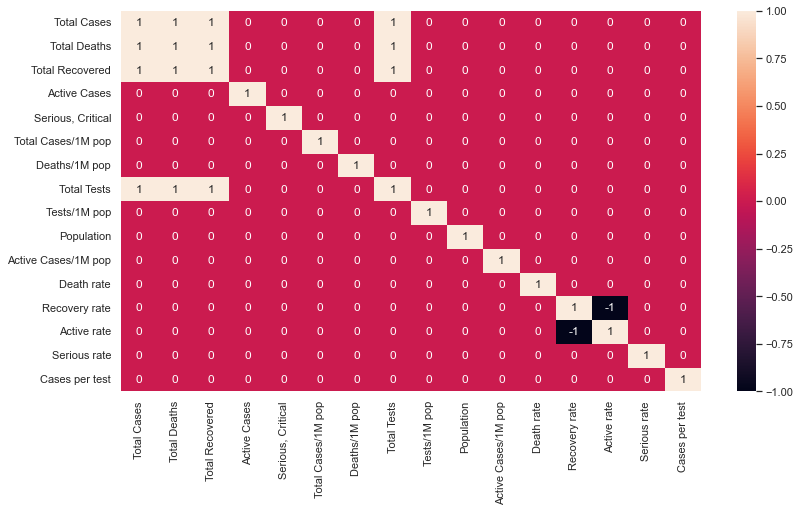

In [6]:
corr = df.corr()

def set_value_for_corr(x):
    if x > 0.7:
        return 1
    elif x < -0.7:
        return -1
    else:
        return 0
    

corr = corr.applymap(set_value_for_corr)
plt.figure(figsize=(13, 7))
sns.heatmap(corr, annot=True)


Ta có mối quan hệ tính toán sao: Total Cases = Active Cases + Total Deaths + Total Recovered. Vì vậy sau khi tính tỉ lệ Active rate và Recovery rate có mức tương quan nghịch cao.

## Scatterplot ##

Sử dụng ma trận pairplot để thể hiện rõ hơn phân bố của các điểm dữ liệu khi bắt cặp với nhau

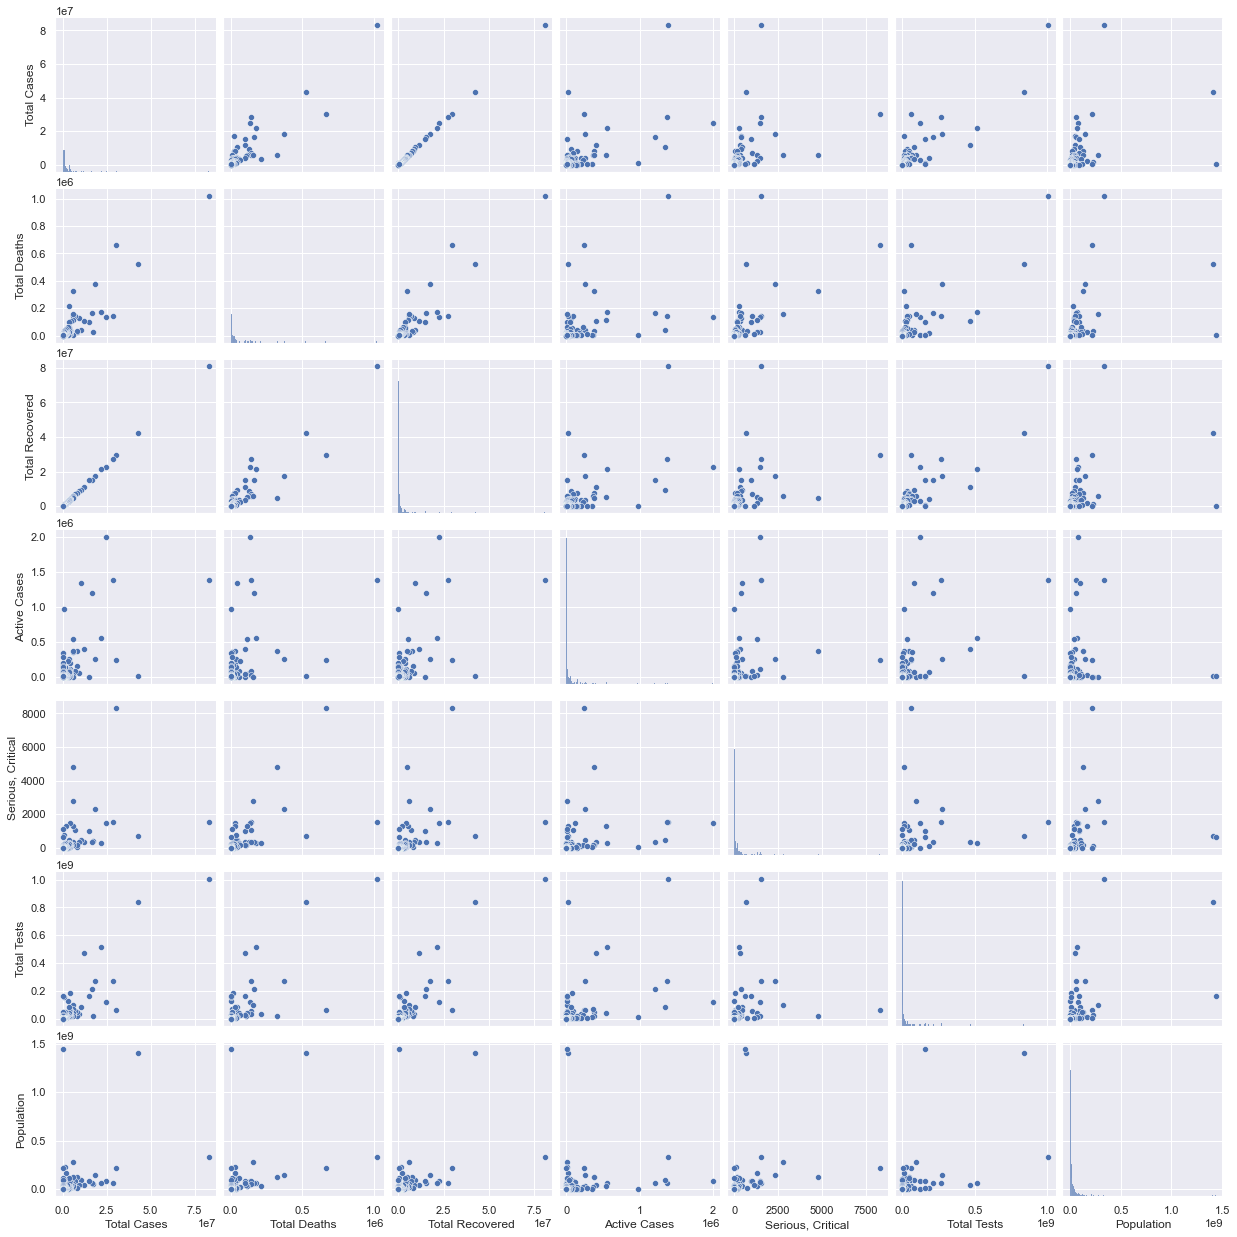

In [8]:
sns.pairplot(data=df[['Total Cases', 'Total Deaths', 
                        'Total Recovered', 'Active Cases', 
                        'Serious, Critical', 'Total Tests', 'Population']]);

## Scatterplot + Regression ##

Vẽ đường hồi quy tuyến tính để xem xét một số mối quan hệ nhân quả giữa các trường dữ liệu

In [10]:
def scatter_with_regression_plot(x_col, y_col):
    fig, ax = plt.subplots()
    sns.scatterplot(x=x_col, y=y_col)
    sns.regplot(x=x_col, y=y_col, ci=None, scatter=False, color='orange', line_kws={'linewidth':3});

### Mối quan hệ giữa các cột `Total Tests`, `Population`, `Total Deaths` và `Total Cases` ###

- Ý nghĩa của cột `Tests/1M pop` chính là tỉ lệ test trên 1 triệu dân, cũng là thương của cột `Total Tests` và cột `Population`.
- Cột `Death Rate` được tính bằng thương của cột `Total Deaths` và `Total Cases`.

Như vậy qua việc trực quan giữa cột `Test/1M pop` và `Death Rate`, ta sẽ xem được mối quan hệ giữa 4 cột `Total Tests`, `Population`, `Total Deaths` và `Total Cases`.

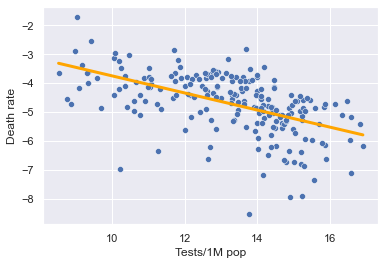

In [11]:
scatter_with_regression_plot(np.log(df['Tests/1M pop']), np.log(df['Death rate']))

Có vẻ như khi tích cực thực hiện test covid, chúng ta sẽ nhanh chóng phòng ngừa được dịch bệnh và giảm tỉ lệ tử vong của những người mắc bệnh.

### Mối quan hệ giữa tỉ lệ mắc bệnh và tỉ lệ tử vong của 1 quốc gia ###

Ta sẽ xem xét liệu có mối quan hệ giữa 2 cột `Total Cases/1M pop` và `Deaths/1M pop`. 

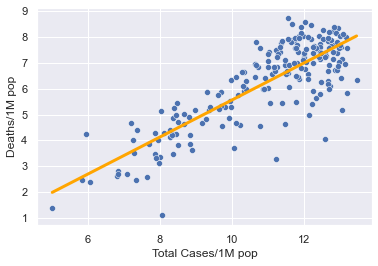

In [12]:
scatter_with_regression_plot(np.log(df['Total Cases/1M pop']), np.log(df['Deaths/1M pop']))

Có vẻ như một quốc gia có tỉ lệ mắc trên tổng dân số càng cao thì tử lệ tử vong trên tổng dân số cũng cao. Ta tiếp tục trực quan trên 2 cột `Total Cases` và `Total Deaths`.

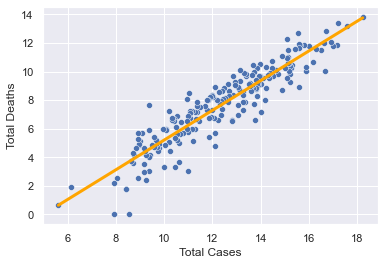

In [13]:
scatter_with_regression_plot(np.log(df['Total Cases']), np.log(df['Total Deaths']))

## So sánh tỉ lệ số ca hiện tại giữa các châu lục ##

Ta tiến hành nhóm các dòng dữ liệu theo châu lục và tính mean để có các tỉ lệ trung bình theo từng châu lục. Sau đó ta xem xét các chây lục có tỉ lệ số ca đang mắc bệnh và tỉ lệ tử vong giảm dần

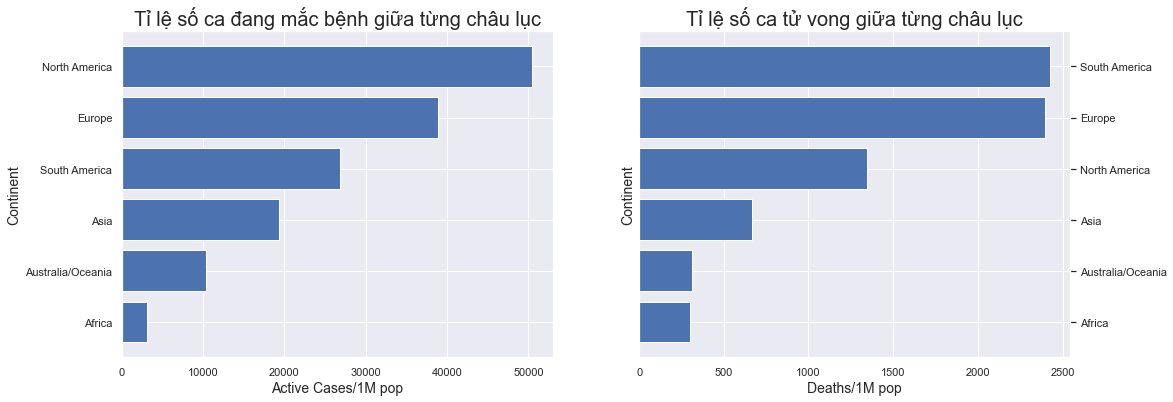

In [189]:
grouped_by_continent = df.groupby(['Continent'])
active_cases_mean = grouped_by_continent['Active Cases/1M pop'].mean().sort_values()
death_cases_mean = grouped_by_continent['Deaths/1M pop'].mean().sort_values()
fig, ax = plt.subplots(1, 2, figsize=(17,6))

ax[0].barh(active_cases_mean.keys(), active_cases_mean.values)
ax[0].set_xlabel('Active Cases/1M pop', fontsize=14)
ax[0].set_ylabel('Continent', fontsize=14)
ax[0].set_title('Tỉ lệ số ca đang mắc bệnh giữa từng châu lục', fontsize=20)

ax[1].barh(death_cases_mean.keys(), death_cases_mean.values)
ax[1].set_xlabel('Deaths/1M pop', fontsize=14)
ax[1].set_ylabel('Continent', fontsize=14)
ax[1].set_title('Tỉ lệ số ca tử vong giữa từng châu lục', fontsize=20)
ax[1].yaxis.tick_right()

Đi sâu hơn vào từng châu lục, ta xem top 3 nước thuộc châu lục đó có tỉ lệ active case và tỉ lệ tử vong cao nhất

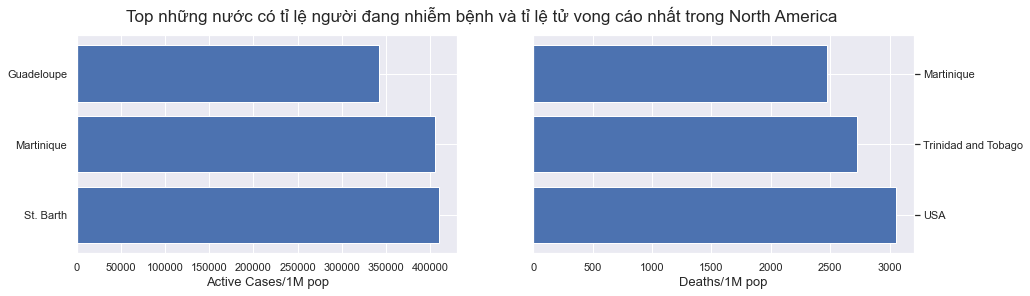

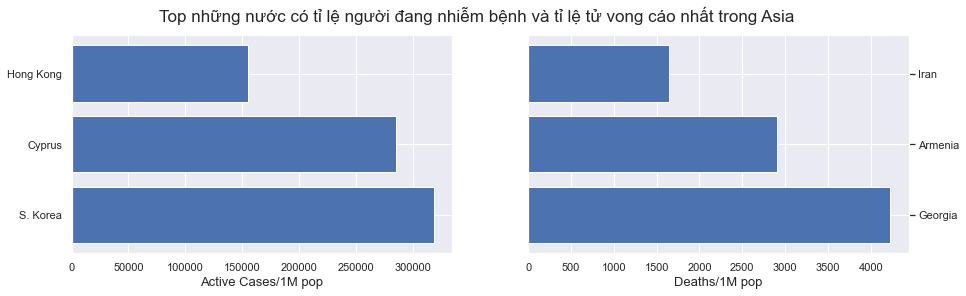

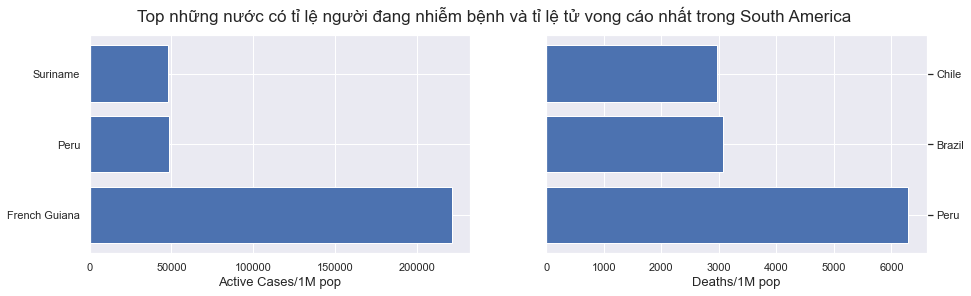

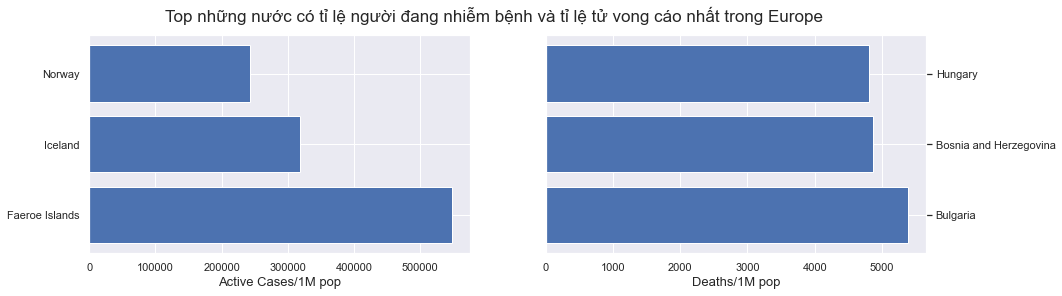

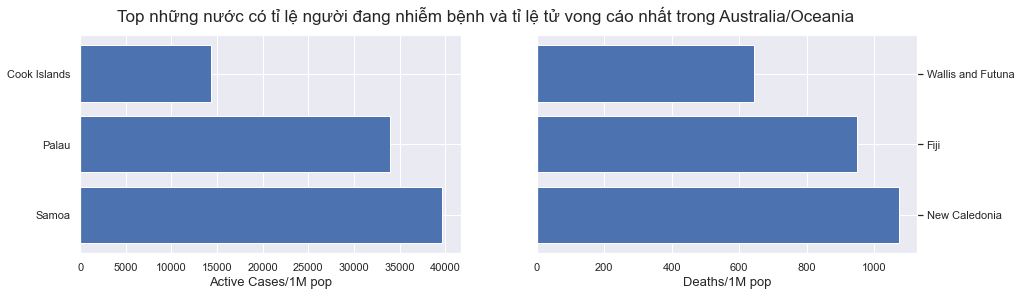

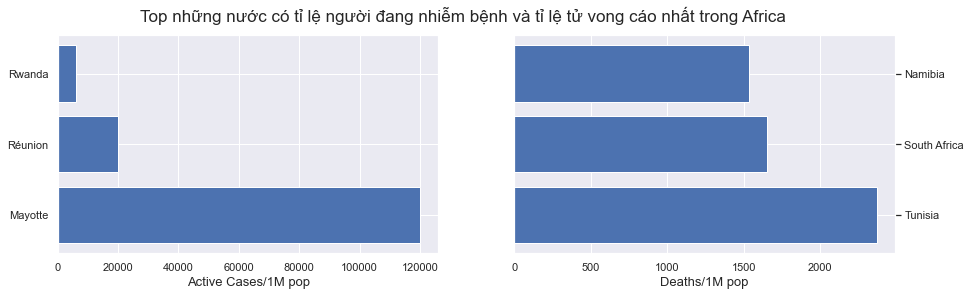

In [177]:
continents = df['Continent'].unique()
for i in range(len(continents)):
    
    fig, ax = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle(f'Top những nước có tỉ lệ người đang nhiễm bệnh và tỉ lệ tử vong cáo nhất trong {continents[i]}', fontsize=17)
    by_continent = df[df['Continent'] == continents[i]]
    temp = by_continent[['Country', 'Active Cases/1M pop']].set_index('Country').sort_values('Active Cases/1M pop', ascending=False)
    ax[0].barh(temp[:3].index, temp[:3].values.reshape(-1))
    ax[0].set_xlabel('Active Cases/1M pop', fontsize=13)
    
    temp = by_continent[['Country', 'Deaths/1M pop']].set_index('Country').sort_values('Deaths/1M pop', ascending=False)
    ax[1].yaxis.tick_right()
    ax[1].barh(temp[:3].index, temp[:3].values.reshape(-1))
    ax[1].set_xlabel('Deaths/1M pop', fontsize=13)